In [1]:
import os
import time
import copy
import torch
import torchvision
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
from sklearn.metrics import average_precision_score, recall_score, f1_score

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Dataset

In [3]:
class HashtagDataset(Dataset):
    def __init__(self, root_dir, csv_file, transform=None):
        self.root_dir = root_dir
        self.hashtag_df = pd.read_csv(csv_file, sep=" ")
        self.transform = transform
        self.num_hashtags = 0
        self.index2hashtag = {}
        self.hashtag2index = {}
        self.create_index()
    
    def create_index(self):
        for i, row in self.hashtag_df.iterrows():
            hashtags = row["hashtags"].split(",")
            for hashtag in hashtags:
                if hashtag not in self.hashtag2index:
                    self.hashtag2index[hashtag] = self.num_hashtags
                    self.index2hashtag[self.num_hashtags] = hashtag
                    self.num_hashtags += 1
    
    def __len__(self):
        return len(self.hashtag_df)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_name = os.path.join(self.root_dir, self.hashtag_df.iloc[idx]["image_path"])
        image = Image.open(img_name)
        image = image.convert('RGB')
        
        hashtags = self.hashtag_df.iloc[idx]["hashtags"]
        hashtags_list = hashtags.split(",")
        
        labels = np.zeros(self.num_hashtags)
        
        for hashtag in hashtags_list:
            labels[self.hashtag2index[hashtag]] = 1
        
        if self.transform:
            image = self.transform(image).float()
            labels = torch.from_numpy(labels.T).float()
        
        return image, labels    

#### Train and Val Transforms

In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

#### Image visualizations

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

#### Train and Validation Dataset

In [6]:
train_dataset = HashtagDataset(root_dir="/scratch/talsperre/hashtag_data",
                               csv_file="train.csv", 
                               transform=train_transform)

val_dataset = HashtagDataset(root_dir="/scratch/talsperre/hashtag_data", 
                               csv_file="val.csv",
                               transform=val_transform)

#### Train and Validation dataloader

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=True, num_workers=4)

#### Visualize images

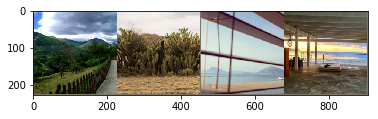

In [8]:
# Get a batch of training data
inputs, labels = next(iter(train_dataloader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)

### Training

In [9]:
def compute_precision(labels, outputs):
    labels = labels.data.cpu().numpy().astype(np.int16)
    outputs = torch.sigmoid(outputs).data > 0.5
    outputs = outputs.data.cpu().numpy().astype(np.int16)
    
    precision = average_precision_score(labels, outputs, average='micro')
    return precision

In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_prec = 0.0
    
    epoch_train_loss = []
    epoch_val_loss = []
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_dataloader
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_dataloader   
            
            running_loss = 0.0
            running_precision = 0.0
            
            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    precision = compute_precision(labels, outputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    
                running_loss += loss.item() * inputs.size(0)
                running_precision += precision * inputs.size(0)

            if phase == 'train':
                scheduler.step()
                epoch_loss = running_loss / len(train_dataset)
                epoch_precision = running_precision / len(train_dataset)
                epoch_train_loss.append(epoch_loss)
            else:
                epoch_loss = running_loss / len(val_dataset)
                epoch_precision = running_precision / len(val_dataset)
                epoch_val_loss.append(epoch_loss)

            print('{} Loss: {:.4f} Prec: {:.4f}'.format(phase, epoch_loss, epoch_precision))

            # deep copy the model
            if phase == 'val' and epoch_precision > best_prec:
                best_prec = epoch_precision
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Prec: {:4f}'.format(best_prec))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, epoch_train_loss, epoch_val_loss

### Finetuning Resnet-50

In [11]:
model_conv = torchvision.models.resnet50(pretrained=True)
# model_conv = model_conv.double()
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 100)

model_conv = model_conv.to(device)

criterion = nn.BCEWithLogitsLoss()

# optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)
optimizer_conv = optim.Adam(model_conv.fc.parameters(), lr=0.01)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_conv, step_size=12, gamma=0.1)

In [12]:
model_conv, epoch_train_loss, epoch_valid_loss = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=35)
torch.save(model_conv.state_dict(), "model.pth")

Epoch 0/34
----------
train Loss: 0.4248 Prec: 0.0894
val Loss: 0.8411 Prec: 0.0427

Epoch 1/34
----------
train Loss: 0.4399 Prec: 0.0898
val Loss: 0.8819 Prec: 0.0425

Epoch 2/34
----------
train Loss: 0.4423 Prec: 0.0914
val Loss: 0.9799 Prec: 0.0426

Epoch 3/34
----------
train Loss: 0.4504 Prec: 0.0929
val Loss: 0.9540 Prec: 0.0433

Epoch 4/34
----------
train Loss: 0.4518 Prec: 0.0934
val Loss: 0.8596 Prec: 0.0467

Epoch 5/34
----------
train Loss: 0.4506 Prec: 0.0926
val Loss: 0.9602 Prec: 0.0432

Epoch 6/34
----------
train Loss: 0.4575 Prec: 0.0916
val Loss: 0.8905 Prec: 0.0433

Epoch 7/34
----------
train Loss: 0.4464 Prec: 0.0956
val Loss: 0.8991 Prec: 0.0435

Epoch 8/34
----------
train Loss: 0.4548 Prec: 0.0939
val Loss: 1.1567 Prec: 0.0417

Epoch 9/34
----------
train Loss: 0.4512 Prec: 0.0962
val Loss: 1.0462 Prec: 0.0427

Epoch 10/34
----------
train Loss: 0.4585 Prec: 0.0942
val Loss: 1.0264 Prec: 0.0422

Epoch 11/34
----------
train Loss: 0.4520 Prec: 0.0943
val Loss:

ValueError: x and y must have same first dimension, but have shapes (10,) and (35,)

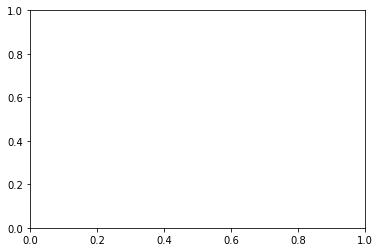

In [13]:
import matplotlib.pyplot as plt

x = np.arange(10)
plt.plot(x, epoch_train_loss, 'g', label='Train Loss')
plt.plot(x, epoch_val_loss, 'b', label='Val Loss')
plt.legend()

In [ ]:
for g in optim.param_groups:
    g['lr'] = 0.0001

In [ ]:
model_conv, epoch_train_loss, epoch_valid_loss = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=35)
torch.save(model_conv.state_dict(), "model.pth")